## 1.0 Explore raw data and prepare songs for analysis

> **Note:** this works for the recordings of a given year only

### This notebook does the following:
 - Segments raw recordings into manually defined songs
 - Segments songs into syllables

**You need to define previous steps: **
 - Copy full lenght recordings
 - Segment songs with AviaNZ
 - Segment into syllables with chipper

In [1]:
# Reload modules automatically
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import src
import glob
import joblib

import warnings
warnings.filterwarnings(action="once")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

from os import fspath

import matplotlib.pyplot as plt
%matplotlib inline

from IPython import get_ipython
from vocalseg.dynamic_thresholding import *
from avgn.dataset import DataSet
from avgn.utils.hparams import HParams
from avgn.utils.paths import most_recent_subdirectory
from tqdm.autonotebook import tqdm
from src.read.paths import DATA_DIR, RESOURCES_DIR
from src.audio.segmentation import *
from IPython.display import display, HTML, display_html

In [3]:
# import recorded nestboxes
files_path = DATA_DIR / "raw" / "2020"
filelist = np.sort(list(files_path.glob("**/*.WAV")))
recorded_nestboxes = pd.DataFrame(set([file.parent.name for file in filelist]))

# import the latest brood data downloaded from https://ebmp.zoo.ox.ac.uk/broods
brood_data_path = RESOURCES_DIR / "brood_data" / "2020"
list_of_files = glob.glob(fspath(brood_data_path) + "/*.csv")
latest_file = max(list_of_files, key=os.path.getctime)
greti_nestboxes = pd.DataFrame(
    (pd.read_csv(latest_file).query('Species == "g"').filter(["Pnum"]))["Pnum"].str[5:]
)
# get those in both lists
recorded_gretis = [
    i
    for i in recorded_nestboxes.values.tolist()
    if i in greti_nestboxes.values.tolist()
]

print("You recorded a total of " + str(len(filelist)) + " hours of audio.")
print(
    "You recorded "
    + str(len(recorded_gretis))
    + " out of a total of "
    + str(len(greti_nestboxes))
    + " great tits that bred this year"
)

You recorded a total of 42 hours of audio.
You recorded 2 out of a total of 260 great tits that bred this year


### Segment raw recordings into bouts
 - Songs manually selected in AviaNZ - for now

> `batch_segment_bouts()` usis multiprocessing. If you run into problems, use `batch_segment_bouts_single()` (much slower).

In [12]:
origin = DATA_DIR / "raw" / "2020" # Folder to segment
DT_ID = dt.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
DATASET_ID = "GRETI_HQ"
threshold = 5000

batch_segment_songs(origin, DATA_DIR, DT_ID, subset=DATASET_ID, threshold = 5000)


{Reading, trimming and saving songs}: 0it [00:00, ?it/s]Complete
total time (s)= 0.110260009765625

{Reading, trimming and saving songs}: 100%|██████████| 31/31 [00:00<00:00, 6246.32it/s]
[Errno 17] File exists: '/home/nilomr/projects/0.0_great-tit-song/test/processed/GRETI_HQ/2020-09-03_16-16-28/JSON'
[Errno 17] File exists: '/home/nilomr/projects/0.0_great-tit-song/test/processed/GRETI_HQ/2020-09-03_16-16-28/JSON'
[Errno 17] File exists: '/home/nilomr/projects/0.0_great-tit-song/test/processed/GRETI_HQ/2020-09-03_16-16-28/JSON'
[Errno 17] File exists: '/home/nilomr/projects/0.0_great-tit-song/test/processed/GRETI_HQ/2020-09-03_16-16-28/JSON'
[Errno 17] File exists: '/home/nilomr/projects/0.0_great-tit-song/test/processed/GRETI_HQ/2020-09-03_16-16-28/JSON'
Complete
total time (s)= 200.2329752445221
{Reading, trimming and saving songs}: 100%|██████████| 41/41 [00:00<00:00, 10945.61it/s]
Complete
total time (s)= 247.5788927078247


- Let's check how many songs have been exported:

In [5]:

all_songs_path = most_recent_subdirectory(DATA_DIR / 'processed' / DATASET_ID)
all_songs_list = np.sort(list(all_songs_path.glob('**/*.wav')))
print('There are ' + str(len(all_songs_list)) + ' songs')


There are 749 songs


# Syllable segmentation

### Create dataset

In [6]:

# Dataset label
DATASET_ID = "GRETI_HQ"

# datetime identifier for output folder
DT_ID = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
DT_ID

hparams = HParams(
    n_fft=1024,
    win_length_ms=4,
    hop_length_ms=3,
    mel_lower_edge_hertz=1200,
    mel_upper_edge_hertz=9000,
    butter_lowcut=1200,
    butter_highcut=9000,
    ref_level_db=30,
    min_level_db=-30,
    n_jobs=-2,
    verbosity=1,
    nex=-1,
)


# create a dataset object
dataset = DataSet(DATASET_ID, hparams=hparams)


# Check a sample json
dataset.sample_json


    unclosed file <_io.TextIOWrapper name='/home/nilomr/projects/0.0_great-tit-song/test/processed/GRETI_HQ/2020-09-03_16-16-28/JSON/W71-GRETI_HQ-20200420_060000-8.wav.JSON' mode='r' encoding='UTF-8'>
loading json: 100%|██████████| 748/748 [00:02<00:00, 290.58it/s]
[Parallel(n_jobs=-2)]: Done 748 out of 748 | elapsed:    2.8s finished
getting unique individuals:   0%|          | 0/748 [00:00<?, ?it/s]ImportWarning:
    can't resolve package from __spec__ or __package__, falling back on __name__ and __path__


OrderedDict([('species', 'GRETI_HQ'),
             ('nestbox', 'W71'),
             ('indvs',
              OrderedDict([('W71',
                            OrderedDict([('species',
                                          'GRETI_HQplaceholder')]))])),
             ('recorder', '24F319045E06342B'),
             ('recordist', 'Nilo Merino Recalde'),
             ('source_datetime', '2020-04-20 06:00:00'),
             ('datetime', '2020-04-20 06:48:35.423270'),
             ('date', '2020-04-20'),
             ('time', '06:48:35.423270'),
             ('timezone', 'UTC'),
             ('samplerate_hz', 48000),
             ('length_s', 2.85225),
             ('lower_freq', 2510),
             ('upper_freq', 4461),
             ('max_amplitude', 17003.0),
             ('min_amplitude', -17898.0),
             ('bit_depth', 16),
             ('tech_comment',
              'Recorded at 06:00:00 20/04/2020 (UTC) by AudioMoth 24F319045E06342B at gain setting 3 while battery state was 3.9V.'

### Define parameters

In [16]:
# Segmentation parameters
parameters = {
    "n_fft": 1024,
    "hop_length_ms": 3,
    "win_length_ms": 15,
    "ref_level_db": 30,
    "pre": 0.4,
    "min_level_db": -26,
    "min_level_db_floor": -13,
    "db_delta": 7,
    "silence_threshold": 0.2,
    "min_silence_for_spec": 0.001,
    "max_vocal_for_spec": (0.4,),
    "min_syllable_length_s": 0.03,
    "spectral_range": [1200, 9000],
}

# There needs to be a silence of at least min_silence_for_spec length,
# and a syllable no longer than max_vocal_for_spec length

### Check a sample song

    unclosed file <_io.BufferedReader name=62>
    unclosed file <_io.BufferedReader name=64>


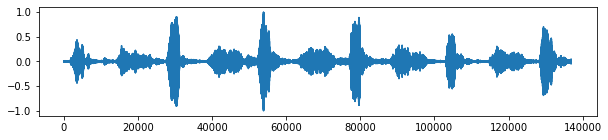

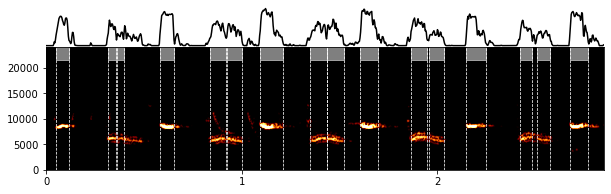

In [14]:
rate, data = load_wav(dataset.sample_json["wav_loc"])
butter_min = dataset.sample_json["lower_freq"]
butter_max = dataset.sample_json["upper_freq"]
data = butter_bandpass_filter(data, butter_min, butter_max, rate)
data = librosa.util.normalize(data)

plt.figure(figsize=(10, 2))
plt.plot(data)

results = dynamic_threshold_segmentation(data, rate, **parameters)

plot_segmentations(
    results["spec"],
    results["vocal_envelope"],
    results["onsets"],
    results["offsets"],
    hop_length_ms=3,
    rate=rate,
    figsize=(10, 3),
)

plt.show()

### Test segmentation in a subset of the data

files:   0%|          | 0/5 [00:00<?, ?it/s]MP58
    unclosed file <_io.BufferedReader name=62>
    unclosed file <_io.BufferedReader name=64>


  0%|          | 0/2 [00:00<?, ?it/s]

longest silence 0.11099999999999999
longest vocalization 0.15599999999999997


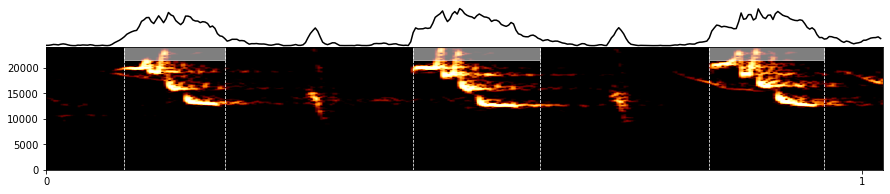


files:  20%|██        | 1/5 [00:00<00:02,  1.48it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=61>
    unclosed file <_io.BufferedReader name=63>


  0%|          | 0/2 [00:00<?, ?it/s]

longest silence 0.153
longest vocalization 0.22200000000000003


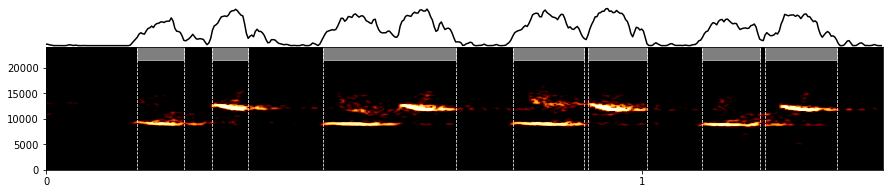


files:  40%|████      | 2/5 [00:01<00:02,  1.49it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=61>
    unclosed file <_io.BufferedReader name=63>


  0%|          | 0/2 [00:00<?, ?it/s]

longest silence 0.09899999999999998
longest vocalization 0.10499999999999998


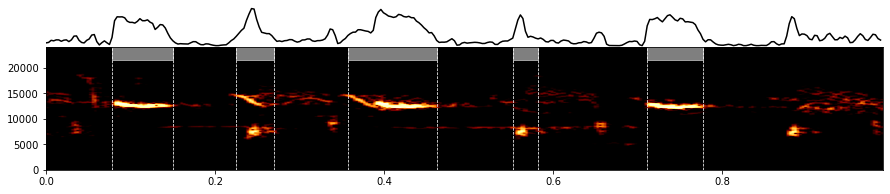


files:  60%|██████    | 3/5 [00:02<00:01,  1.30it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=61>
    unclosed file <_io.BufferedReader name=63>


  0%|          | 0/2 [00:00<?, ?it/s]

longest silence 0.135
longest vocalization 0.132


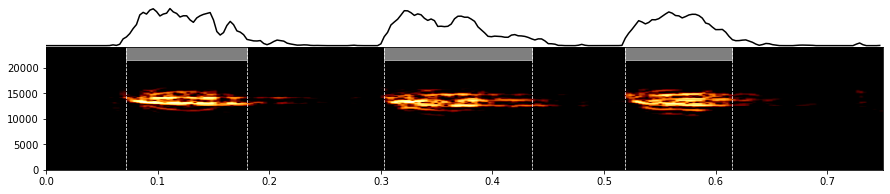


files:  80%|████████  | 4/5 [00:03<00:00,  1.32it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=61>
    unclosed file <_io.BufferedReader name=63>


  0%|          | 0/2 [00:00<?, ?it/s]

longest silence 0.10799999999999998
longest vocalization 0.11699999999999999


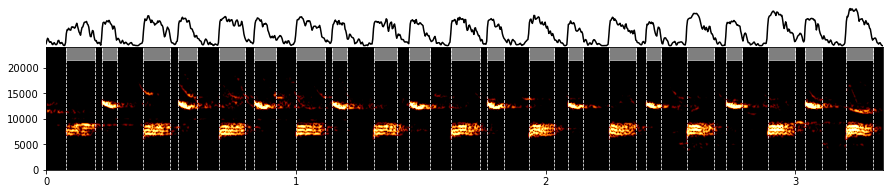


files:   0%|          | 0/5 [00:00<?, ?it/s]W71
    unclosed file <_io.BufferedReader name=61>
    unclosed file <_io.BufferedReader name=63>


  0%|          | 0/2 [00:00<?, ?it/s]

longest silence 0.17700000000000002
longest vocalization 0.21000000000000002


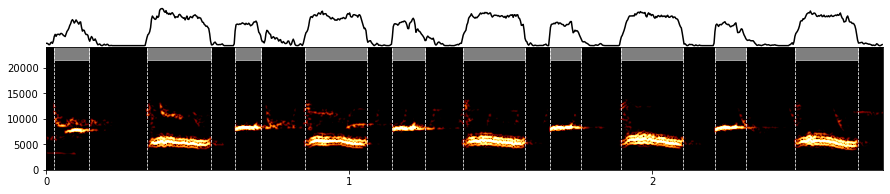


files:  20%|██        | 1/5 [00:00<00:03,  1.20it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=61>
    unclosed file <_io.BufferedReader name=63>


  0%|          | 0/2 [00:00<?, ?it/s]

longest silence 0.156
longest vocalization 0.20100000000000007


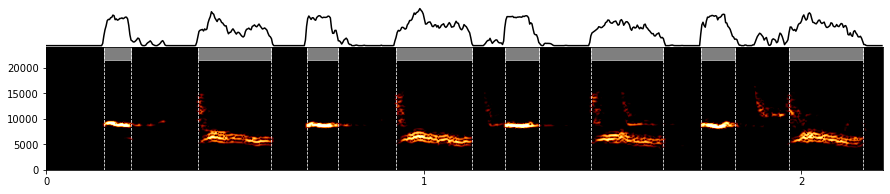


files:  40%|████      | 2/5 [00:01<00:02,  1.21it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=61>
    unclosed file <_io.BufferedReader name=63>


  0%|          | 0/2 [00:00<?, ?it/s]

longest silence 0.11399999999999999
longest vocalization 0.19800000000000006


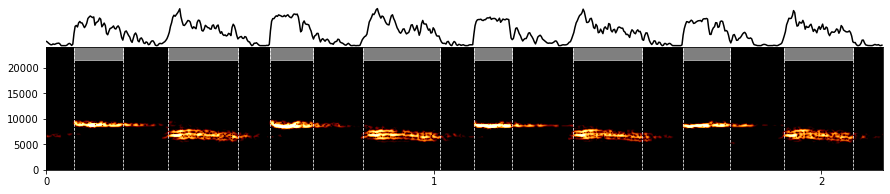


files:  60%|██████    | 3/5 [00:02<00:01,  1.23it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=61>
    unclosed file <_io.BufferedReader name=63>


  0%|          | 0/2 [00:00<?, ?it/s]

longest silence 0.16799999999999993
longest vocalization 0.14100000000000001


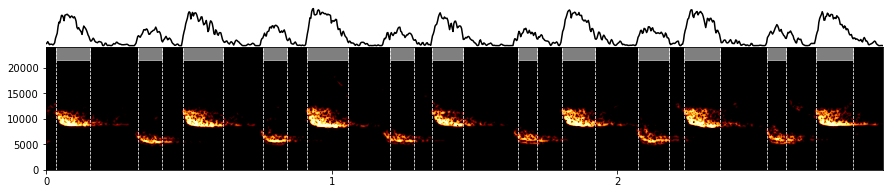


files:  80%|████████  | 4/5 [00:03<00:00,  1.25it/s]ResourceWarning:
    unclosed file <_io.BufferedReader name=61>
    unclosed file <_io.BufferedReader name=63>


  0%|          | 0/2 [00:00<?, ?it/s]

longest silence 0.132
longest vocalization 0.15000000000000002


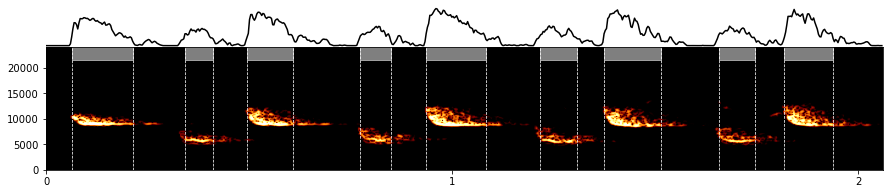


individuals: 100%|██████████| 2/2 [00:07<00:00,  3.96s/it]


In [17]:

indvs = np.array(["_".join(list(i)) for i in dataset.json_indv])
np.unique(indvs)

for indv in tqdm(np.unique(indvs), desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[indvs == indv][20:25]

    joblib.Parallel(n_jobs=1, verbose=0)(
        joblib.delayed(segment_spec_custom)(
            key, dataset.data_files[key], **parameters, plot=True
        )
        for key in tqdm(indv_keys, desc="files", leave=False)
    )

### Segment full dataset

In [18]:
nex = -1
for indv in tqdm(np.unique(indvs), desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[indvs == indv]

    joblib.Parallel(n_jobs=-2, verbose=1)(
        joblib.delayed(segment_spec_custom)(
            key, dataset.data_files[key], **parameters, save=True
        )
        for key in tqdm(indv_keys, desc="files", leave=False)
    )

files:   0%|          | 0/335 [00:00<?, ?it/s]MP58
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.

files:  13%|█▎        | 42/335 [00:05<00:29, 10.10it/s][Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    5.9s

files:  59%|█████▊    | 196/335 [00:18<00:12, 11.48it/s][Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   19.0s

files:  98%|█████████▊| 329/335 [00:30<00:00, 11.66it/s]
[Parallel(n_jobs=-2)]: Done 335 out of 335 | elapsed:   32.1s finished
files:   0%|          | 0/413 [00:00<?, ?it/s][Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
W71

files:  10%|█         | 42/413 [00:02<00:28, 13.15it/s][Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    3.5s

files:  47%|████▋     | 196/413 [00:17<00:20, 10.79it/s][Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:   17.8s

files: 100%|██████████| 413/413 [00:39<00:00, 10.22it/s]
[Parallel(n_jobs=-2)]: Done 413 out of 413 | elapsed:   40.2s finished
individuals: 10